In [24]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, Activation, GlobalMaxPooling1D, Input, Conv2D, Reshape, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow.random as random

seed = 111
random.set_seed(seed)
np.random.seed(seed)

In [2]:
df = pd.read_csv("cleaned_data/cleaned_reviews_3.csv")
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review,text,rating,sentiment,detoken
0,"This started out strong, but it went downhill ...","[start, out, strong, but, go, downhill, fairly...",1,0,start out strong but go downhill fairly quickl...
1,"A decently written YA book, but I can't even c...","[decently, write, ya, book, but, can, even, co...",1,0,decently write ya book but can even consider e...
2,"Ugh...I tried, I honestly tried. I'm a huge fa...","[ugh, try, honestly, try, huge, fan, scott, we...",1,0,ugh try honestly try huge fan scott westerfeld...
3,Main points: \n 1. Never ever introduce a poin...,"[main, point, never, ever, introduce, point, v...",1,0,main point never ever introduce point view sid...
4,Why do all YA books have to have a love triang...,"[all, ya, book, love, triangle, now, just, who...",1,0,all ya book love triangle now just whole world...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     11400 non-null  object
 1   text       11400 non-null  object
 2   rating     11400 non-null  int64 
 3   sentiment  11400 non-null  int64 
 4   detoken    11400 non-null  object
dtypes: int64(2), object(3)
memory usage: 445.4+ KB


In [4]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 222)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")

There are 515575 train words in total and the vocabulary size is 18590.


In [5]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# max_length = max(max([len(x) for x in train_sequences]), max([len(x) for x in test_sequences]))
max_length = 150

x_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(max_length)
print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

150
(9120, 150)
(2280, 150)
(9120,)
(2280,)
Found 18616 unique tokens


In [6]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [7]:
vocab_train = vocab_build(df_train["text"])
vocab_test = vocab_build(df_test["text"])

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(df_train["text"], embeddings_dict)
test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test["text"], embeddings_dict)

print(f"Glove embeddings cover {round(train_vocab_coverage, 2)}% of vocabulary and {round(train_text_coverage, 2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage, 2)}% of vocabulary and {round(test_text_coverage, 2)}% text in testing set")

Glove embeddings cover 95.22% of vocabulary and 99.79% text in training set
Glove embeddings cover 97.13% of vocabulary and 99.76% text in testing set


In [10]:
EMBEDDING_DIM = 300
MAX_WORDS = 15000
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False)

del(embedding_matrix)

#### Model - Sequential

In [31]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 300)          4500000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,691,041
Trainable params: 191,041
Non-trainable params: 4,500,000
______________________________________

In [32]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.05

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
114/114 [==============================] - 17s 132ms/step - loss: 0.6650 - accuracy: 0.6120 - val_loss: 0.8414 - val_accuracy: 0.6606
Epoch 2/5
114/114 [==============================] - 14s 125ms/step - loss: 0.5969 - accuracy: 0.6853 - val_loss: 0.9337 - val_accuracy: 0.4589
Epoch 3/5
114/114 [==============================] - 15s 127ms/step - loss: 0.5806 - accuracy: 0.7055 - val_loss: 0.6874 - val_accuracy: 0.6771
Epoch 4/5
114/114 [==============================] - 17s 146ms/step - loss: 0.5504 - accuracy: 0.7294 - val_loss: 0.6145 - val_accuracy: 0.7922
Epoch 5/5
114/114 [==============================] - 17s 152ms/step - loss: 0.5351 - accuracy: 0.7381 - val_loss: 0.7416 - val_accuracy: 0.6891


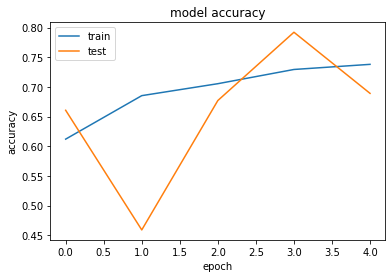

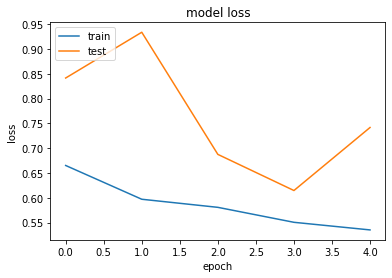

In [33]:
# Plot accuracy and loss

plot_history(history)

In [34]:
# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

72/72 - 3s - loss: 0.5509 - accuracy: 0.7474 - 3s/epoch - 35ms/step
Test accuracy: 0.7473683953285217


#### Model - Input

In [11]:
sequence_input = Input(shape=(max_length,), dtype="int32")
embedded_sequences = embedding_layer(sequence_input)
# x = Conv1D(256, 10, activation="relu")(embedded_sequences)
x = LSTM(128, return_sequences=True)(embedded_sequences)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 300)          4500000   
                                                                 
 lstm_1 (LSTM)               (None, 150, 128)          219648    
                                                                 
 dropout_1 (Dropout)         (None, 150, 128)          0         
                                                                 
 dense_2 (Dense)             (None, 150, 64)           8256      
                                                                 
 dense_3 (Dense)             (None, 150, 1)            65        
                                                                 
Total params: 4,727,969
Trainable params: 227,969
Non-train

In [12]:
# Compile model

EPOCHS = 10
LEARNING_RATE = 0.001
# DECAY_RATE = LEARNING_RATE / EPOCHS

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

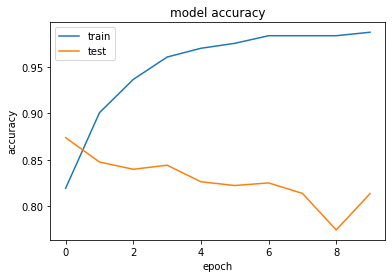

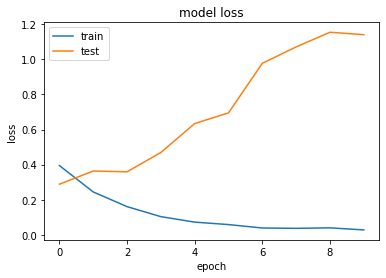

In [16]:
# Plot accuracy and loss
plot_history(history)

In [17]:
# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

125/125 - 13s - loss: 0.9092 - accuracy: 0.8562 - 13s/epoch - 108ms/step
Test accuracy: 0.856249988079071
